# Federated Learning - Partie Réimplémentation
- nicolas.schmitt
- nicolas.schmitt@epita.fr

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
import torchvision
from torchvision import datasets, transforms
import numpy as np
from typing import List, Tuple, Dict
import copy

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

## 1. Load the MNIST dataset (or any other dataset like HAM 10000)

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
])
    
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)
train_dataset, test_dataset

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 59809205.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1709025.03it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 15250977.78it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5370884.91it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

## 2. Extract two subsets of 600 data points each (without intersection)

In [3]:
def create_subsets(dataset, subset_size=600):
    
    indices = torch.randperm(len(dataset))
    
    subset1_indices = indices[:subset_size]
    subset2_indices = indices[subset_size:subset_size * 2]
    
    subset1 = Subset(dataset, subset1_indices)
    subset2 = Subset(dataset, subset2_indices)
    
    return subset1, subset2

train_dataset1, train_dataset2 = create_subsets(train_dataset)
train_dataset1, train_dataset2

(<torch.utils.data.dataset.Subset at 0x7b8adefffeb0>,
 <torch.utils.data.dataset.Subset at 0x7b8adefff8e0>)

## 3. Create a simple Convolutional Neural Network (2 convolutional layers and 2 dense layers, for example)

In [4]:
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## 4. Create a function average_model_parameters(models: iterable, average_weight): iterable that takes a list of models as an argument and returns the weighted average of the parameters of each model.

In [5]:
def average_model_parameters(models, average_weights):
    avg_params = {}
    
    for name, param in models[0].state_dict().items():
        avg_params[name] = torch.zeros_like(param)
        
        for model, weight in zip(models, average_weights):
            avg_params[name] += weight * model.state_dict()[name]
            
    return avg_params

## 5. Create a function that updates the parameters of a model from a list of values

In [6]:
def update_model_parameters(model, parameters):
    model.load_state_dict(parameters)

## 6. Create a script/code/function that reproduces Algorithm 1, considering that both models are on your machine. Use an average_weight=[1/2, 1/2]. Reuse the same setup as in the article (50 examples per local batch)

In [7]:
def train_distributed(train_dataset1, train_dataset2, test_dataset, model_class, num_epochs=10, batch_size=50, init=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device:", device)
    
    train_loader1 = torch.utils.data.DataLoader(train_dataset1, batch_size=batch_size, shuffle=True)
    train_loader2 = torch.utils.data.DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)
    
    model1 = model_class().to(device)
    model2 = model_class().to(device)
    
    if init:
        common_params = average_model_parameters([model1, model2], [0.5, 0.5])
        update_model_parameters(model1, common_params)
        update_model_parameters(model2, common_params)
    
    optimizer1 = torch.optim.Adam(model1.parameters())
    optimizer2 = torch.optim.Adam(model2.parameters())
    criterion = nn.CrossEntropyLoss()
    
    history = {'acc': [], 'loss': []}
    
    for epoch in range(num_epochs):
        model1.train()
        model2.train()
        
        for (data1, target1), (data2, target2) in zip(train_loader1, train_loader2):
            data1, target1 = data1.to(device), target1.to(device)
            data2, target2 = data2.to(device), target2.to(device)
            
            optimizer1.zero_grad()
            output1 = model1(data1)
            loss1 = criterion(output1, target1)
            loss1.backward()
            optimizer1.step()
            
            optimizer2.zero_grad()
            output2 = model2(data2)
            loss2 = criterion(output2, target2)
            loss2.backward()
            optimizer2.step()
            
            avg_params = average_model_parameters([model1, model2], [0.5, 0.5])
            update_model_parameters(model1, avg_params)
            update_model_parameters(model2, avg_params)
        
        model1.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model1(data)
                test_loss += criterion(output, target).item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        
        test_loss /= len(test_loader)
        accuracy = 100. * correct / len(test_dataset)
        
        history['loss'].append(test_loss)
        history['acc'].append(accuracy)
        
        print(f'Epoch {epoch}: Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')
    
    return model1, history

In [8]:
def plot_training_results(hist):
    plt.figure(figsize=(10, 5))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(hist["acc"], label='Accuracy')
    ax1.set_title('Model Accuracy over Epochs')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy (%)')
    ax1.grid(True)
    ax1.legend()
    
    ax2.plot(hist["loss"], label='Loss', color='red')
    ax2.set_title('Model Loss over Epochs')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()    
    plt.show()

## 7. Train your models without initializing the common parameters and measure the performance on the entire dataset.

Device: cuda
Epoch 0: Loss: 1.5592, Accuracy: 61.71%
Epoch 1: Loss: 0.5895, Accuracy: 81.48%
Epoch 2: Loss: 0.4787, Accuracy: 85.51%
Epoch 3: Loss: 0.3889, Accuracy: 88.06%
Epoch 4: Loss: 0.3130, Accuracy: 90.89%
Epoch 5: Loss: 0.2882, Accuracy: 91.45%
Epoch 6: Loss: 0.2347, Accuracy: 93.13%
Epoch 7: Loss: 0.2362, Accuracy: 92.81%
Epoch 8: Loss: 0.2284, Accuracy: 93.38%
Epoch 9: Loss: 0.2183, Accuracy: 93.43%


<Figure size 1000x500 with 0 Axes>

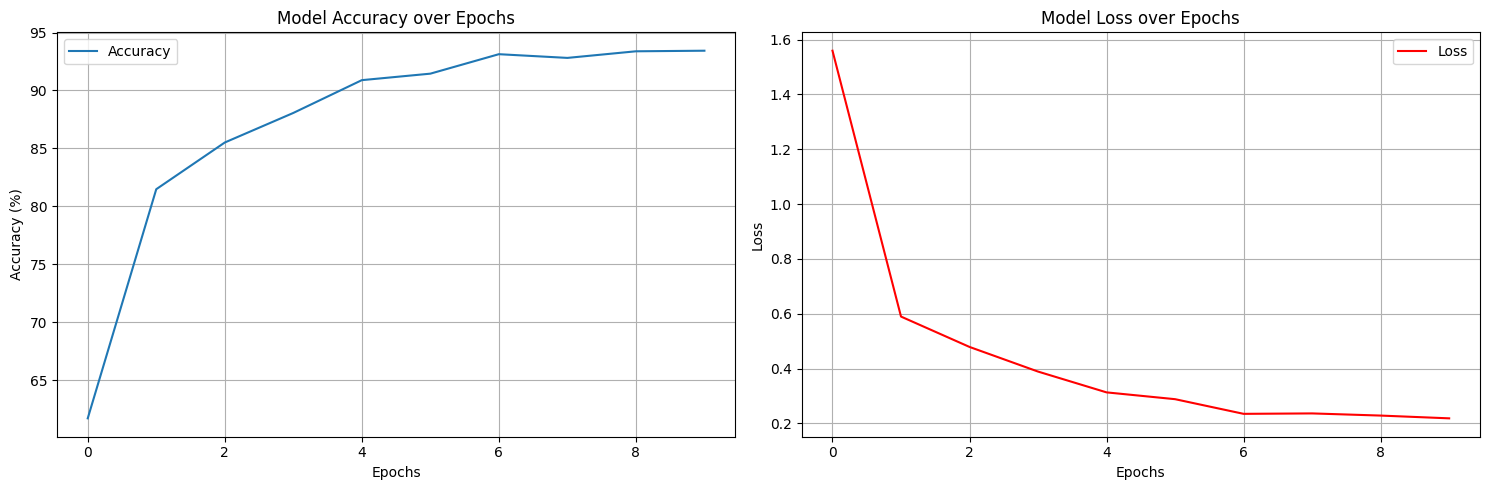

In [9]:
model_without_init, history_without_init = train_distributed(
    train_dataset1, 
    train_dataset2, 
    test_dataset,
    MNIST_CNN,
    init=False
)

plot_training_results(history_without_init)

## 8. Train your models with the initialization of common parameters and verify that the performance is better.

Device: cuda
Epoch 0: Loss: 1.3660, Accuracy: 65.01%
Epoch 1: Loss: 0.6267, Accuracy: 79.96%
Epoch 2: Loss: 0.4636, Accuracy: 86.18%
Epoch 3: Loss: 0.3835, Accuracy: 88.72%
Epoch 4: Loss: 0.3569, Accuracy: 89.40%
Epoch 5: Loss: 0.3031, Accuracy: 90.73%
Epoch 6: Loss: 0.2575, Accuracy: 92.21%
Epoch 7: Loss: 0.2566, Accuracy: 92.23%
Epoch 8: Loss: 0.2281, Accuracy: 93.01%
Epoch 9: Loss: 0.2265, Accuracy: 93.27%


<Figure size 1000x500 with 0 Axes>

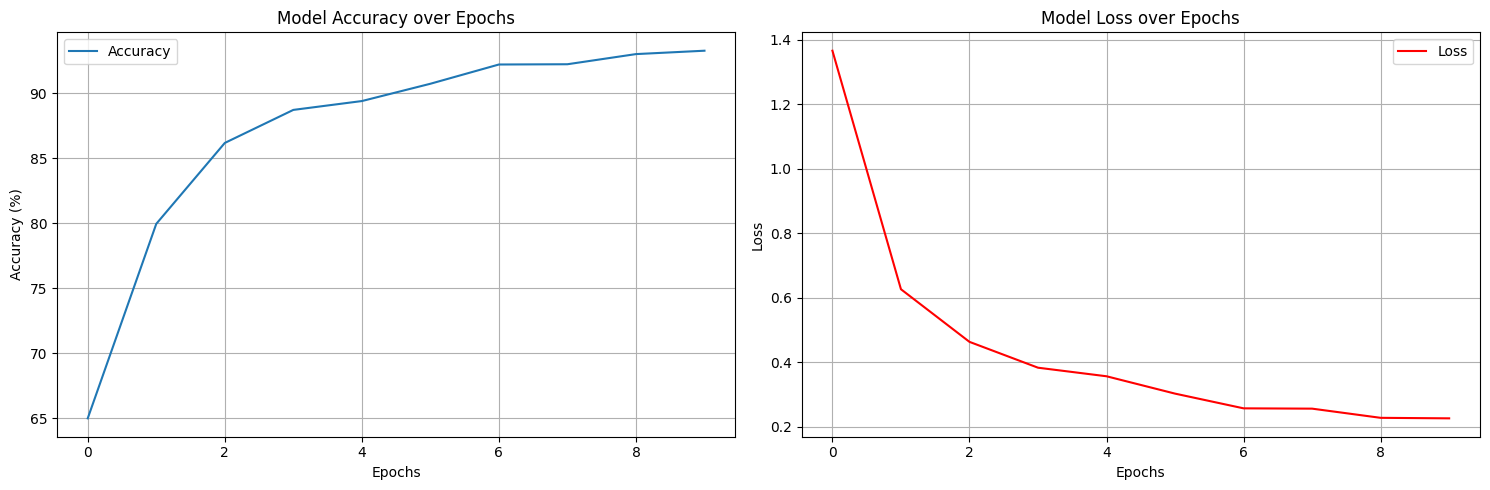

In [10]:
model_with_init, history_with_init = train_distributed(
    train_dataset1, 
    train_dataset2, 
    test_dataset,
    MNIST_CNN,
    init=True
)

plot_training_results(history_with_init)

## 9. Reduce the number of data points in each sub-batch. What is the minimum number of data points necessary for the final model to have acceptable performance? Repeat the study on CIFAR-10

In [11]:
def study_minimum_datapoints(train_dataset, test_dataset, model_class, sizes, num_epochs=10):
    results = {}
    for size in sizes:
        print("\n---------------------------------------------")
        print(f"Testing with {size} datapoints per subset")
        subset1, subset2 = create_subsets(train_dataset, subset_size=size)
        
        _, history = train_distributed(
            subset1, 
            subset2, 
            test_dataset,
            model_class,
            num_epochs=num_epochs,
            batch_size=min(50, size),
            init=True
        )
        results[size] = max(history['acc'])
    return results

sizes = [size for size in range(100, 601, 100)]
results = study_minimum_datapoints(train_dataset, test_dataset, MNIST_CNN, sizes)

print("\n---------------------------------------------")
for size, acc in results.items():
    print(f"Size: {size}, Best accuracy: {acc:.2f}%")




---------------------------------------------
Testing with 100 datapoints per subset
Device: cuda
Epoch 0: Loss: 2.2523, Accuracy: 31.38%
Epoch 1: Loss: 2.1531, Accuracy: 33.24%
Epoch 2: Loss: 1.9821, Accuracy: 43.60%
Epoch 3: Loss: 1.7577, Accuracy: 53.44%
Epoch 4: Loss: 1.5002, Accuracy: 57.73%
Epoch 5: Loss: 1.2162, Accuracy: 69.46%
Epoch 6: Loss: 1.0131, Accuracy: 72.47%
Epoch 7: Loss: 0.8953, Accuracy: 71.50%
Epoch 8: Loss: 0.8231, Accuracy: 72.77%
Epoch 9: Loss: 0.7537, Accuracy: 75.80%

---------------------------------------------
Testing with 200 datapoints per subset
Device: cuda
Epoch 0: Loss: 2.1651, Accuracy: 28.21%
Epoch 1: Loss: 1.8059, Accuracy: 50.38%
Epoch 2: Loss: 1.2943, Accuracy: 66.51%
Epoch 3: Loss: 0.8371, Accuracy: 76.68%
Epoch 4: Loss: 0.6705, Accuracy: 79.96%
Epoch 5: Loss: 0.5791, Accuracy: 82.47%
Epoch 6: Loss: 0.6053, Accuracy: 81.00%
Epoch 7: Loss: 0.5802, Accuracy: 82.75%
Epoch 8: Loss: 0.6847, Accuracy: 78.39%
Epoch 9: Loss: 0.5192, Accuracy: 83.92%

-

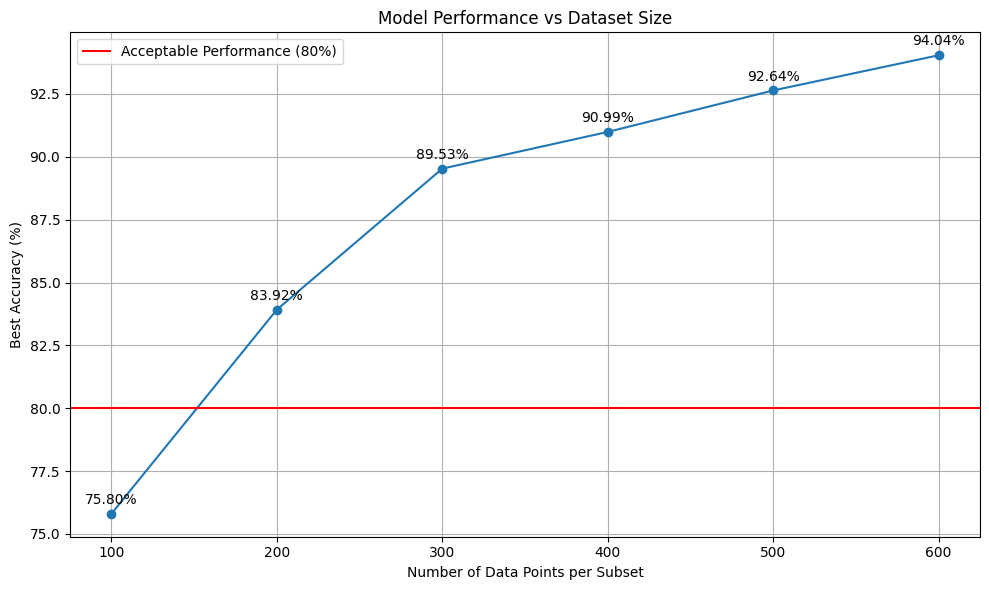

In [12]:
def plot_study_results(results, acceptable_perf=80):
    plt.figure(figsize=(10, 6))
    
    sizes = list(results.keys())
    accuracies = list(results.values())
    
    plt.plot(sizes, accuracies, marker='o')
    
    plt.title('Model Performance vs Dataset Size')
    plt.xlabel('Number of Data Points per Subset')
    plt.ylabel('Best Accuracy (%)')
    plt.grid(True)
    
    for i, j in zip(sizes, accuracies):
        plt.annotate(f'{j:.2f}%', 
                    xy=(i, j), 
                    xytext=(0, 5),
                    textcoords='offset points', 
                    ha='center',
                    va='bottom')

    plt.axhline(y = acceptable_perf, color = 'r', linestyle = '-', label= f"Acceptable Performance ({acceptable_perf}%)") 
    plt.legend()
    
    plt.xticks(sizes)
    plt.tight_layout()
    plt.show()

plot_study_results(results=results)

In [13]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    transform=transform
)
    
train_dataset, test_dataset

100%|██████████| 170498071/170498071 [00:02<00:00, 79477959.22it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
            ))

In [14]:
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


---------------------------------------------
Testing with 10000 datapoints per subset
Device: cuda
Epoch 0: Loss: 1.4790, Accuracy: 46.20%
Epoch 1: Loss: 1.3083, Accuracy: 52.66%
Epoch 2: Loss: 1.2618, Accuracy: 54.59%
Epoch 3: Loss: 1.1454, Accuracy: 59.60%
Epoch 4: Loss: 1.0992, Accuracy: 61.54%
Epoch 5: Loss: 1.0752, Accuracy: 62.25%
Epoch 6: Loss: 1.0562, Accuracy: 63.41%
Epoch 7: Loss: 1.0150, Accuracy: 64.68%
Epoch 8: Loss: 1.0629, Accuracy: 63.75%
Epoch 9: Loss: 1.0384, Accuracy: 65.73%

---------------------------------------------
Testing with 12000 datapoints per subset
Device: cuda
Epoch 0: Loss: 1.4275, Accuracy: 48.50%
Epoch 1: Loss: 1.2592, Accuracy: 55.47%
Epoch 2: Loss: 1.1395, Accuracy: 59.59%
Epoch 3: Loss: 1.0642, Accuracy: 62.51%
Epoch 4: Loss: 1.0402, Accuracy: 63.07%
Epoch 5: Loss: 1.0281, Accuracy: 63.99%
Epoch 6: Loss: 1.0171, Accuracy: 64.88%
Epoch 7: Loss: 0.9937, Accuracy: 66.02%
Epoch 8: Loss: 0.9560, Accuracy: 67.72%
Epoch 9: Loss: 0.9837, Accuracy: 67.44

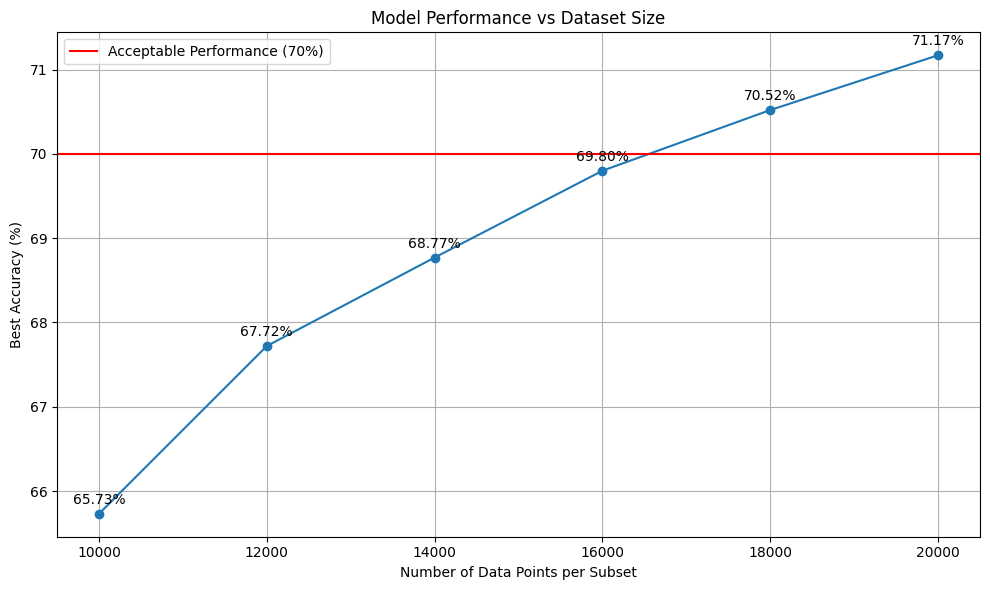

In [15]:
sizes = [size for size in range(10000, 20001, 2000)]
results = study_minimum_datapoints(train_dataset, test_dataset, CIFAR10_CNN, sizes, num_epochs=10)

print("\n---------------------------------------------")
for size, acc in results.items():
    print(f"Size: {size}, Best accuracy: {acc:.2f}%")

plot_study_results(results=results, acceptable_perf=70)